# Load Necessary Libraries :

In [1]:
import os
import tensorflow.keras
import tensorflow as tf
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import sys
import pickle
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.models import Model
import string
import numpy as np
from pickle import load
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM ,GRU, Bidirectional
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout, Reshape, Lambda, Concatenate
# from tensorflow.keras.layers.merge import add
from tensorflow.keras.layers import add
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers
from nltk.translate.bleu_score import corpus_bleu

emb_dim = 200
snaphot_folder = 'weights3/'
batch_size = 256

2021-10-29 07:43:21.185026: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
emb_dim = 200

## Progress bar (to view completion percentage of process) : 

In [3]:
def progressBar(value, endvalue, bar_length=20,job='Job'):

    percent = float(value) / endvalue
    arrow = '-' * int(round(percent * bar_length)-1) + '>'
    spaces = ' ' * (bar_length - len(arrow))

    sys.stdout.write("\r{0} Completion: [{1}] {2}%".format(job,arrow + spaces, int(round(percent * 100))))
    sys.stdout.flush()

## Functions to load dataset :

In [4]:
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    # process line by line
    for line in doc.split('\n'):
        # skip empty lines
        if len(line) < 1:
            continue
        # get the image identifier
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return list(set(dataset))

def load_photo_features(filename, dataset):
    # load all features
    all_features = load(open(filename, 'rb'))
    # filter features
    features = {k: all_features[k] for k in dataset}
    return features

## Load dataset :

In [5]:
doc = load_doc("../input/flicker8k-image-captioning/Flickr8k_text/Flickr8k.token.txt")

In [6]:
descriptions = {}
for line in doc.split('\n'):
    try:
        tokens = line.split()
        image_id, image_desc = tokens[0], tokens[1:]
        # extract filename from image id
        image_id = image_id.split('.')[0]
        # convert description tokens back to string
        image_desc = ' '.join(image_desc)
        if image_id not in descriptions:
            descriptions[image_id] = list()
        descriptions[image_id].append(image_desc)
    except :
        print(line)

In [7]:
# pickle.dump(descriptions, open('descriptions.pkl', 'wb'))

In [8]:
path_check = '../input/flicker8k-image-captioning/Flickr8k_text'

## Visualization of image and respective captions :

1000268201_693b08cb0e ['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']


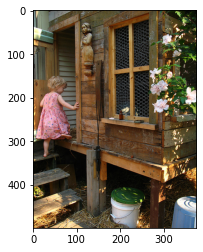

In [9]:
print(next(iter(descriptions)),descriptions[next(iter(descriptions))])

x = plt.imread('../input/flicker8k-image-captioning/Flickr8k_Dataset/Flicker8k_Dataset/'+next(iter(descriptions))+'.jpg')
plt.imshow(x)
plt.show()

## Text preprocessing :

In [10]:
def clean_data(pairs):
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            # tokenize
            desc = desc.split()
            # convert to lower case
            desc = [word.lower() for word in desc]
            # remove punctuation from each token
            desc = [w.translate(table) for w in desc]
            # remove hanging 's' and 'a'
            desc = [word for word in desc if len(word)>0]
            # remove tokens with numbers in them
            desc = [word for word in desc if word.isalpha()]
            # store as string
            desc_list[i] =  ' '.join(desc)
            
    return descriptions

In [11]:
descriptions_clean = clean_data(descriptions)
descriptions[next(iter(descriptions_clean))]

['a child in a pink dress is climbing up a set of stairs in an entry way',
 'a girl going into a wooden building',
 'a little girl climbing into a wooden playhouse',
 'a little girl climbing the stairs to her playhouse',
 'a little girl in a pink dress going into a wooden cabin']

## Add command for text processing :

In [12]:
start_token = '<startseq>'
end_token = '<endseq>'
def add_end_start_tokens(descriptions):
    for key in descriptions:
        for i in range(len(descriptions[key])):
            descriptions[key][i] = start_token + ' ' + descriptions[key][i] + ' ' + end_token
    return descriptions

In [13]:
descriptions_tokenSE = add_end_start_tokens(descriptions_clean)
descriptions_tokenSE[next(iter(descriptions_tokenSE))]

['<startseq> a child in a pink dress is climbing up a set of stairs in an entry way <endseq>',
 '<startseq> a girl going into a wooden building <endseq>',
 '<startseq> a little girl climbing into a wooden playhouse <endseq>',
 '<startseq> a little girl climbing the stairs to her playhouse <endseq>',
 '<startseq> a little girl in a pink dress going into a wooden cabin <endseq>']

In [14]:
def load_train_test(descriptions, dataset):
    dataset_ = {}
    for image_id in dataset:
        dataset_[image_id] = descriptions[image_id]
        
    return dataset_

## Loading training and validation sets :

In [15]:
train_imgs_addr = '../input/flicker8k-image-captioning/Flickr8k_text/Flickr_8k.trainImages.txt'
test_imgs_addr = '../input/flicker8k-image-captioning/Flickr8k_text/Flickr_8k.testImages.txt'
dev_imgs_addr = '../input/flicker8k-image-captioning/Flickr8k_text/Flickr_8k.devImages.txt'

train_imgs_names = load_set(train_imgs_addr)
test_imgs_names = load_set(test_imgs_addr)
dev_imgs_names = load_set(dev_imgs_addr)

len(train_imgs_names), len(test_imgs_names), len(dev_imgs_names)

(6000, 1000, 1000)

In [16]:
train_imgs_names[:5]

['3518443604_6da641f07d',
 '1184967930_9e29ce380d',
 '2971211296_2587c3924d',
 '407569668_19b3f8eaf6',
 '3687995245_624b54090d']

In [17]:
train_descriptions = load_train_test(descriptions_tokenSE, train_imgs_names)
dev_descriptions = load_train_test(descriptions_tokenSE, dev_imgs_names)
test_descriptions = load_train_test(descriptions_tokenSE, test_imgs_names)

In [18]:
# pickle.dump(train_descriptions, open('train_descriptions.pkl', 'wb'))
# pickle.dump(test_descriptions, open('test_descriptions.pkl', 'wb'))
# pickle.dump(dev_descriptions, open('dev_descriptions.pkl', 'wb'))

## Vocabulary out of corpus available :

In [19]:
# making a vocabulary of the words that occur more than word_count_threshold time
def create_reoccurring_vocab(descriptions, word_count_threshold = 10):
    # Create a list of all the captions
    all_captions = []
    for key, val in descriptions.items():
        for cap in val:
            all_captions.append(cap)

    # Consider only words which occur at least 10 times in the corpus
    word_counts = {}
    nsents = 0
    for sent in all_captions:
        nsents += 1
        for w in sent.split(' '):
            word_counts[w] = word_counts.get(w, 0) + 1

    vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

    return vocab

In [20]:
vocab = create_reoccurring_vocab(train_descriptions, word_count_threshold = 2)
sorted(vocab)[:10]

['<endseq>',
 '<startseq>',
 'a',
 'abandon',
 'abandoned',
 'about',
 'above',
 'abseiling',
 'ac',
 'accented']

In [21]:
oov_token = '<UNK>'
filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n' # making sure all the last non digit non alphabet chars are removed
tokenizer = tensorflow.keras.preprocessing.text.Tokenizer(filters = filters, oov_token=oov_token)
tokenizer.fit_on_texts(vocab)
vocab_size = len(tokenizer.word_index) + 1
print('vocab_size :', vocab_size)

vocab_size : 4483


In [22]:
ixtoword = {} # index to word dic
wordtoix = {} # word to index dic

tokenizer.word_index['<PAD0>'] = 0 # no word in vocab has index 0. but padding is indicated with 0
wordtoix = tokenizer.word_index # word to index dic

for w in tokenizer.word_index:
    ixtoword[tokenizer.word_index[w]] = w

In [23]:
# pickle.dump(wordtoix, open('wordtoix.pkl', 'wb'))
# pickle.dump(ixtoword, open('ixtoword.pkl', 'wb'))
# pickle.dump(vocab, open('vocab.pkl', 'wb'))

In [24]:
print(tokenizer)

In [25]:
# finding the maximum length of questions and answers
# because there are senteces with unusually long lengths, 
# we caculate the max length that p% of data can be placed in
def max_length(desc,p):
    all_desc = []
    # Create a list of all the captions
    for i in desc:
        for j in desc[i]:
            all_desc.append(j)

    length_all_desc = list(len(d.split()) for d in all_desc)

    print('percentile {} of len of questions: {}'.format(p,np.percentile(length_all_desc, p)))
    print('longest sentence: ', max(length_all_desc))

    return int(np.percentile(length_all_desc, p))

max_length = max_length(train_descriptions,90)

print('max-len answer for training: ', max_length)

percentile 90 of len of questions: 18.0
longest sentence:  37
max-len answer for training:  18


In [26]:
max_length

18

# Xception Neural Net :

In [27]:
xception = Xception()
extractor = Model(inputs=xception.inputs, outputs=xception.layers[-2].output) # removing 2 last fully connected layers 
print(extractor.summary())

2021-10-29 07:43:55.957614: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-29 07:43:55.961557: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-29 07:43:56.006437: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-29 07:43:56.007397: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-10-29 07:43:56.007440: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-29 07:43:56.038216: I tensorflow/stream_executor/platform/def

91889664/91884032 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
_____________________________

# Feature extraction from image :

In [28]:
def extract_features(description, model, inpute_size = (299,299)):
    directory = '../input/flicker8k-image-captioning/Flickr8k_Dataset/Flicker8k_Dataset'
    features = {}
    i = 0
    for name in description:
        progressBar(value=i,endvalue=len(descriptions))
        i +=1
        filename =os.path.join(directory, name+'.jpg')
#         print(filename)
        image = load_img(filename, target_size=inpute_size)
        image = img_to_array(image)
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        image = preprocess_input(image)
        print(image.shape)
        feature = model.predict(image, verbose=0)
        image_id = name.split('.')[0]
        features[image_id] = feature.reshape(2048)
    return features

## Feature extraction from training & validation files :

In [ ]:
# train_features = extract_features(train_descriptions, extractor)

In [ ]:
# test_features = extract_features(test_descriptions, extractor)

In [ ]:
# dev_features = extract_features(dev_descriptions, extractor)

## Dumping Extracted features into pickle file :

In [ ]:
# pickle.dump(train_features, open('train_features.pkl', 'wb'))
# pickle.dump(test_features, open('test_features.pkl', 'wb'))
# pickle.dump(dev_features, open('dev_features.pkl', 'wb'))

## Loading image vectors from pickle files :

In [29]:
with open('../input/img-captioning-weight-files/weights_and_files/dev_features.pkl','rb') as f:
    dev_features= pickle.load(f)    
with open('../input/img-captioning-weight-files/weights_and_files/train_features.pkl','rb') as f:
    train_features= pickle.load(f)
with open('../input/img-captioning-weight-files/weights_and_files/test_features.pkl','rb') as f:
    test_features= pickle.load(f)

In [30]:
len(descriptions), len(train_features)

(8092, 6000)

In [31]:
# outputs a batch of captions-pictures
def data_generator(descriptions, photos):
    X1, X2, y = [], [], []
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key]
            for desc in desc_list:
                # find the index of each word of the caption in vocabulary
                seq = tokenizer.texts_to_sequences(desc.split())
                # split one sequence into multiple X, y pairs
                # Each step of the following for loop selects one word
                # from the caption, consider that word as y and
                # all the words before that will be the X
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i] # words until i are inseq word i is outseq
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]

                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n == 1500:
                yield [[np.array(X1), np.array(X2).squeeze(axis=-1)], np.array(y).squeeze(axis=-1)]
                X1, X2, y = list(), list(), list()
                n=0

In [32]:
d = next(data_generator(train_descriptions, train_features))
d[0][0].shape, d[0][1].shape, d[1].shape

((88249, 2048), (88249, 18), (88249,))

In [33]:
len(train_descriptions), len(train_features)

(6000, 6000)

## Assign weights for word embedding using glove.6B.200d file :

## Manual loss function :

In [34]:
# for masking pad0 outputs
def masked_loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = K.sparse_categorical_crossentropy(real, pred, from_logits= False) # sparse cat gets pred classes in 'int' form
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

# Custom model for IMAGE + TEXT :

In [35]:
import os
# Load Glove vectors
glove_dir = '../input/glove6b200d'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [36]:
embedding_dim = 200
# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [37]:
embedding_matrix.shape

(4483, 200)

In [38]:
# pickle.dump(embedding_matrix, open('embedding_matrix.pkl', 'wb'))

In [39]:
import pandas as pd
len(pd.Series(d[1]).unique())

3157

In [40]:
cnn_input = Input(shape=(2048,))
c1 = Dropout(0.5)(cnn_input)
c2 = Dense(256, activation='relu')(c1)


lstm_input = Input(shape=(18,)) # shape from train_data
l1 = Embedding(vocab_size, 200, input_length = 18, mask_zero=True)(lstm_input)
d1 = Dropout(0.5)(l1)
l2 = Bidirectional(LSTM(128, return_sequences=False))(d1) # --> ERROR
# dense = Dense(1, activation='softmax')(lstm) 


concat = add([c2, l2])
concat_2 = Dense(16000, activation='relu')(concat)
concat_3 = Dense(8000, activation='relu')(concat_2)
concat_4 = Dense(5000, activation='relu')(concat_3)
output = Dense(vocab_size-2, activation='softmax')(concat_2)


model = Model(inputs=[cnn_input, lstm_input], outputs=output)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 18)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 18, 200)      896600      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [42]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

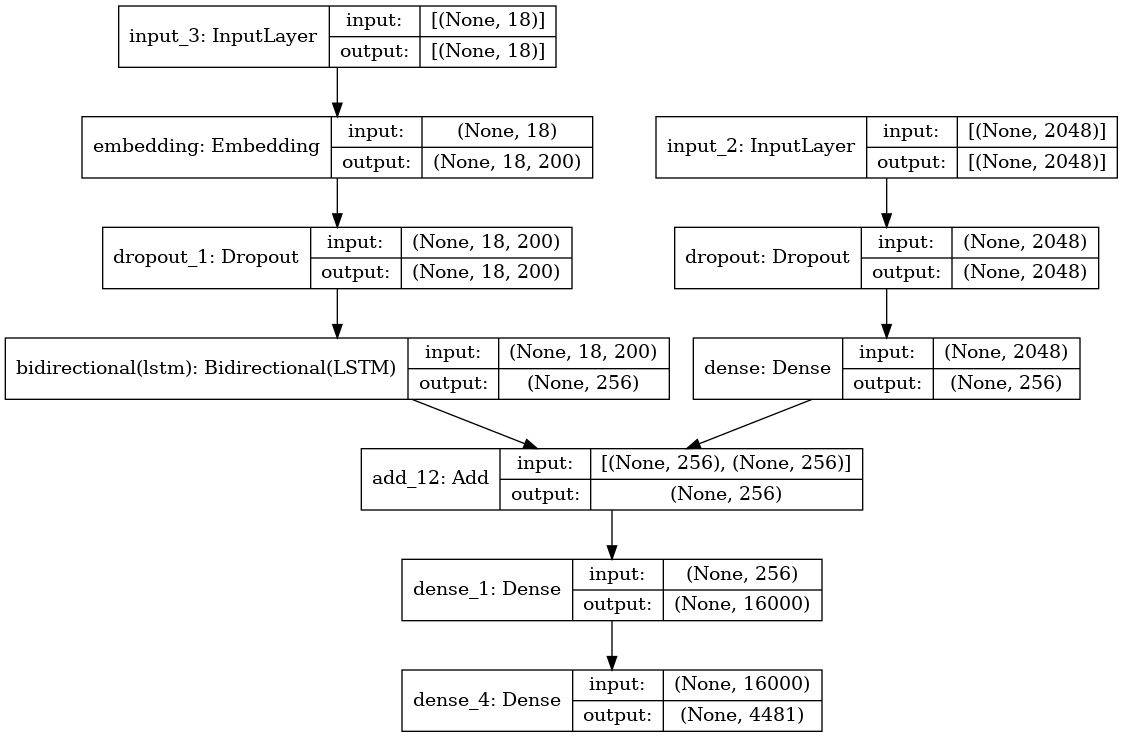

In [43]:
plot_model(model, to_file='model3.png', show_shapes=True)

In [44]:
model.compile(loss=masked_loss_function, optimizer= 'adam', metrics=[tf.keras.metrics.sparse_categorical_accuracy])

In [45]:
history={'loss':[], 'BLEU_val':[]}

## To generate random description using trained model :

In [46]:
# generate a description for an image greedy way
def generate_desc(model, photo_fe, inference= False):
    # seed the generation process
    in_text = start_token
    # iterate over the whole length of the sequence
    # generate one word at each iteratoin of the loop
    # appends the new word to a list and makes the whole sentence
    for i in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences(in_text.split()) #[wordtoix[w] for w in in_text.split() if w in wordtoix]
        # pad input
        photo_fe = photo_fe.reshape((1,2048))
        sequence = pad_sequences([sequence], maxlen=max_length).reshape((1,max_length))
        # predict next word
        yhat = model.predict([photo_fe,sequence], verbose=0)
        # convert probability to integer
        yhat = np.argmax(yhat)
        # map integer to word
        word = ixtoword[yhat]
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next v
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == end_token:
            break
            
    if inference == True:
        in_text = in_text.split()
        if len(in_text) == max_length:
            in_text = in_text[1:] # if it is already at max len and endseq hasn't appeared
        else:
            in_text = in_text[1:-1]
        in_text = ' '.join(in_text)
        
    return in_text

In [47]:
def beam_search_pred(model, pic_fe, wordtoix, K_beams = 3, log = False):
    start = [wordtoix[start_token]]
    
    start_word = [[start, 0.0]]
    
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            sequence  = pad_sequences([s[0]], maxlen=max_length).reshape((1,max_length)) #sequence of most probable words 
                                                                                         # based on the previous steps
            preds = model.predict([pic_fe.reshape(1,2048), sequence])
            word_preds = np.argsort(preds[0])[-K_beams:] # sort predictions based on the probability, then take the last
                                                         # K_beams items. words with the most probs
            # Getting the top <K_beams>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                if log:
                    prob += np.log(preds[0][w]) # assign a probability to each K words4
                else:
                    prob += preds[0][w]
                temp.append([next_cap, prob])
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])

        # Getting the top words
        start_word = start_word[-K_beams:]
    
    start_word = start_word[-1][0]
    captions_ = [ixtoword[i] for i in start_word]

    final_caption = []
    
    for i in captions_:
        if i != end_token:
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

# BLEU :

In [48]:
# calculating BLEU score of predictions
def evaluate_model(model, descriptions, photos_fe, K_beams= 3, log=False):
    actual, predicted = list(), list()
    # step over the whole set
    i=0
    for key, desc_list in descriptions.items():
        # generate description
        i+=1
        progressBar(i, len(descriptions), bar_length=20,job='Evaluating')
        if K_beams == 1:
            yhat = generate_desc(model, photos_fe[key])
        else:
            yhat=beam_search_pred(model, photos_fe[key], wordtoix, K_beams = K_beams,log=log)
        
        # store actual and predicted
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
        
    # calculate BLEU score
    b1=corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    b2=corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    b3=corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))
    b4=corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
    print('\n')
    print('BLEU-1: %f' % b1)
    print('BLEU-2: %f' % b2)
    print('BLEU-3: %f' % b3)
    print('BLEU-4: %f' % b4)
    return [b1,b2,b3,b4]

## Reduction in learning rate :

In [49]:
# checkpoint_path = 'training_1/cp.ckpt'
from tensorflow.keras.callbacks import ReduceLROnPlateau
Reduce_lr= ReduceLROnPlateau(monitor='loss', factor=0.9, patience=5, verbose=0, mode='auto', min_delta=0.0001, min_lr=0.000001)
# cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only=True, verbose=1)

## Testing on random sample :

====


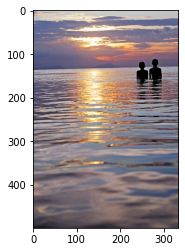

2021-10-29 07:46:03.285885: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-29 07:46:03.297880: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199995000 Hz
2021-10-29 07:46:05.702877: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-10-29 07:46:06.584217: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-10-29 07:46:07.762892: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


Greedy: fights lots rowers come droplets droplets rusty tank tank tank tank tank tank tank tank tank tank


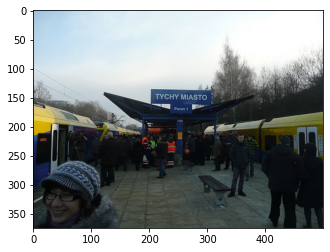

Greedy: changes changes kart professional changes kart professional kart establishment creating professional creating professional creating professional creating professional


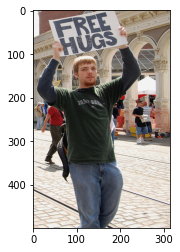

Greedy: professional professional professional professional lockers professional professional professional professional professional professional professional professional professional professional professional professional


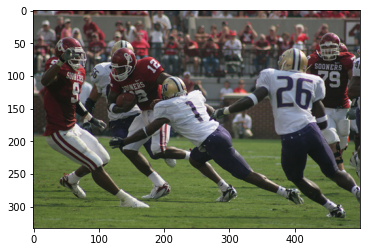

Greedy: helmets overweight face face sweats face pointer pointer pointer pointer pointer pointer pointer pointer pointer pointer pointer
====


In [50]:
def test(i=np.random.randint(len(test_features)), j=np.random.randint(len(test_features)),
         k=np.random.randint(len(test_features)), q=np.random.randint(len(test_features)), show_pic=False):
    print('====')
    pic = list(test_features.keys())[i]
    fe = test_features[pic].reshape((1,2048))
    if show_pic:
        x=plt.imread('../input/flicker8k-image-captioning/Flickr8k_Dataset/Flicker8k_Dataset/'+pic+'.jpg')
        plt.imshow(x)
        plt.show()
    print("Greedy:",generate_desc(model, fe, inference=True))
    
    pic = list(test_features.keys())[j]
    fe = test_features[pic].reshape((1,2048))
    if show_pic:
        x=plt.imread('../input/flicker8k-image-captioning/Flickr8k_Dataset/Flicker8k_Dataset/'+pic+'.jpg')
        plt.imshow(x)
        plt.show()
    print("Greedy:",generate_desc(model, fe, inference=True))
    
    pic = list(test_features.keys())[k]
    fe = test_features[pic].reshape((1,2048))
    if show_pic:
        x=plt.imread('../input/flicker8k-image-captioning/Flickr8k_Dataset/Flicker8k_Dataset/'+pic+'.jpg')
        plt.imshow(x)
        plt.show()
    print("Greedy:", generate_desc(model, fe, inference=True))
    pic = list(test_features.keys())[q]
    fe = test_features[pic].reshape((1,2048))
    if show_pic:
        x=plt.imread('../input/flicker8k-image-captioning/Flickr8k_Dataset/Flicker8k_Dataset/'+pic+'.jpg')
        plt.imshow(x)
        plt.show()
    print("Greedy:",generate_desc(model, fe, inference=True))

    print('====')
    
    
test(show_pic=True)    

In [51]:
steps = len(train_descriptions)//16

In [52]:
steps

375

In [53]:
vocab_size

4483

In [54]:
import pandas as pd
len(pd.Series(d[1]).unique())

3157

In [55]:
target = tf.keras.utils.to_categorical(d[1], num_classes=vocab_size-2, dtype="int32")

In [56]:
target.shape

(88249, 4481)

# Model Training :

In [57]:
ep=1

In [58]:
tf.config.run_functions_eagerly(True)        # x=[d[0][0], d[0][1]], y=d[1]

In [59]:
import pandas as pd
dummy_y = pd.Series(d[1])
dummy_y.shape

(88249,)

In [65]:
for a in range(1,20):
    
    print('Epoch :',a,'\n')
    # fit for one epoch
    h = model.fit(x=[d[0][0], d[0][1]], y=d[1], epochs=1, batch_size=batch_size, verbose=1, callbacks=[Reduce_lr] , validation_split=0.20)
    ep = a + 1
    history['loss'].append(h.history['loss'])
    print('\n','='*100)

Epoch : 1 

276/276 [==============================] - 74s 269ms/step - loss: 0.2965 - sparse_categorical_accuracy: 0.8896 - val_loss: 7.6134 - val_sparse_categorical_accuracy: 0.3250

Epoch : 2 

276/276 [==============================] - 72s 262ms/step - loss: 0.2942 - sparse_categorical_accuracy: 0.8892 - val_loss: 7.6063 - val_sparse_categorical_accuracy: 0.3265

Epoch : 3 

276/276 [==============================] - 72s 260ms/step - loss: 0.2951 - sparse_categorical_accuracy: 0.8895 - val_loss: 7.7598 - val_sparse_categorical_accuracy: 0.3347

Epoch : 4 

276/276 [==============================] - 72s 261ms/step - loss: 0.2950 - sparse_categorical_accuracy: 0.8892 - val_loss: 7.6172 - val_sparse_categorical_accuracy: 0.3334

Epoch : 5 

276/276 [==============================] - 71s 259ms/step - loss: 0.2925 - sparse_categorical_accuracy: 0.8899 - val_loss: 7.8077 - val_sparse_categorical_accuracy: 0.3299

Epoch : 6 

276/276 [==============================] - 72s 262ms/step - los

## Loss Curve :

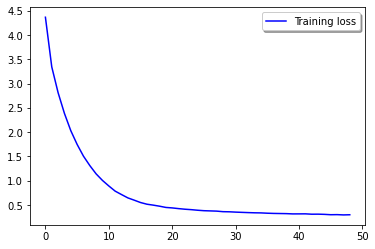

In [61]:
plt.plot(history['loss'], color='b', label='Training loss')
plt.legend(loc='best', shadow=True)
plt.show()

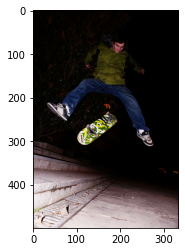

Greedy: a skateboarder is riding his red up
Beam K= 3: a boy on a skateboard is riding on a stone wall
Beam K= 5: a boy on a skateboard is riding on a stone wall
Beam log K= 3: a boy on a skateboard is riding on a stone wall
Beam log K= 5: a boy on a skateboard is riding on a stone wall


In [67]:
pic = list(train_features.keys())[np.random.randint(1,1000)]
fe = train_features[pic].reshape((1,2048))
x=plt.imread('../input/flicker8k-image-captioning/Flickr8k_Dataset/Flicker8k_Dataset/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model, fe, inference=True))
print("Beam K= 3:",beam_search_pred(model, train_features[pic], wordtoix, K_beams = 3, log=False))
print("Beam K= 5:",beam_search_pred(model, train_features[pic], wordtoix, K_beams = 5, log=False))
print("Beam log K= 3:",beam_search_pred(model, train_features[pic], wordtoix, K_beams = 3, log=True))
print("Beam log K= 5:",beam_search_pred(model, train_features[pic], wordtoix, K_beams = 5, log=True))

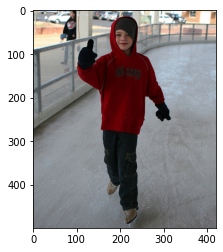

Greedy: a toddler in a red jacket and green hat sits on a snowy hill
Beam K= 3: a boy in a red jacket and balck hat sliding on his knees down a snowy hill
Beam K= 5: an adult is assisting a child in the act of <UNK>
Beam log K= 3: a toddler in a red hat and balck hat sliding on a snowy hill
Beam log K= 5: a toddler in a red hat and balck hat sliding on a snowy hill


In [68]:
pic = list(train_features.keys())[np.random.randint(1,1000)]
fe = train_features[pic].reshape((1,2048))
x=plt.imread('../input/flicker8k-image-captioning/Flickr8k_Dataset/Flicker8k_Dataset/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model, fe, inference=True))
print("Beam K= 3:",beam_search_pred(model, train_features[pic], wordtoix, K_beams = 3, log=False))
print("Beam K= 5:",beam_search_pred(model, train_features[pic], wordtoix, K_beams = 5, log=False))
print("Beam log K= 3:",beam_search_pred(model, train_features[pic], wordtoix, K_beams = 3, log=True))
print("Beam log K= 5:",beam_search_pred(model, train_features[pic], wordtoix, K_beams = 5, log=True))

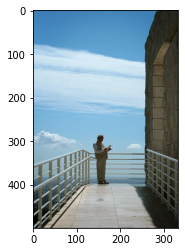

Greedy: a man and a woman on a bench facing a building with trees in the background <endseq>
Beam K= 3: the couple is in the water
Beam K= 5: man and woman walking near the ocean
Beam log K= 3: two people stand against the edge of the water and watch the water
Beam log K= 5: two people stand against the edge of the water and watch the water


In [69]:
pic = list(dev_features.keys())[np.random.randint(1,1000)]
fe = dev_features[pic].reshape((1,2048))
x=plt.imread('../input/flicker8k-image-captioning/Flickr8k_Dataset/Flicker8k_Dataset/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model = model, photo_fe=fe, inference=True))
print("Beam K= 3:",beam_search_pred(model=model, pic_fe=dev_features[pic], wordtoix=wordtoix, K_beams = 3, log=False))
print("Beam K= 5:",beam_search_pred(model=model, pic_fe=dev_features[pic], wordtoix=wordtoix, K_beams = 5, log=False))
print("Beam log K= 3:",beam_search_pred(model=model, pic_fe=dev_features[pic], wordtoix=wordtoix, K_beams = 3, log=True))
print("Beam log K= 5:",beam_search_pred(model=model, pic_fe=dev_features[pic], wordtoix=wordtoix, K_beams = 5, log=True))

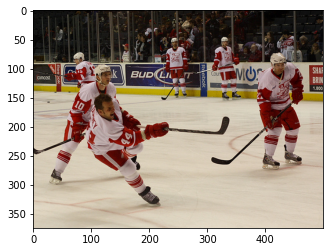

Greedy: a group of speed skaters making a turn with a blue advertisement behind them
Beam K= 3: a group of speed skaters making a turn with a blue advertisement behind them
Beam K= 5: the goalie has come out of the goal to <UNK> the puck from the other team
Beam log K= 3: a group of speed skaters making a turn with a blue advertisement behind them
Beam log K= 5: a group of speed skaters making a turn with a blue advertisement behind them


In [66]:
pic = list(test_features.keys())[560]
fe = test_features[pic].reshape((1,2048))
x=plt.imread('../input/flicker8k-image-captioning/Flickr8k_Dataset/Flicker8k_Dataset/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",generate_desc(model=model, photo_fe=fe, inference=True))
print("Beam K= 3:",beam_search_pred(model = model, pic_fe=test_features[pic], wordtoix = wordtoix, K_beams = 3, log=False))
print("Beam K= 5:",beam_search_pred(model = model, pic_fe=test_features[pic], wordtoix = wordtoix, K_beams = 5, log=False))
print("Beam log K= 3:",beam_search_pred(model = model, pic_fe=test_features[pic], wordtoix = wordtoix, K_beams = 3, log=True))
print("Beam log K= 5:",beam_search_pred(model = model, pic_fe=test_features[pic], wordtoix = wordtoix, K_beams = 5, log=True))